In [1]:
%run utils.ipynb

In [8]:
import shap
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import numpy as np

In [3]:

params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}

adult_data = pd.read_csv('../Datasets/adult_train.csv', index_col=0)
adult_data = adult_data.drop(['education'], axis=1)
data = DataEncoding(adult_data)
df_adult = data.label_encoding()

X = df_adult.drop('target', axis=1)
y = df_adult['target'].astype(bool)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[708]	valid_0's binary_logloss: 0.278161


In [4]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [5]:
explainer.expected_value

-2.374481280821391

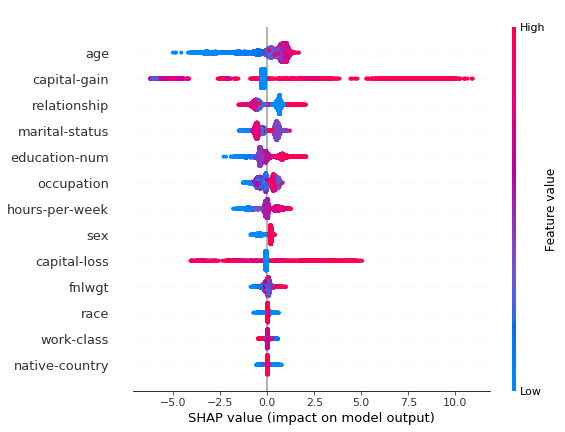

In [6]:
shap.summary_plot(shap_values, X)

In [9]:
df_effect = adult_data.copy()
sex_ind = df_effect.columns.tolist().index('sex')
df_effect['deviation'] = shap_values[:, sex_ind]
df_effect['deviation'] = df_effect['deviation'] - np.mean(df_effect['deviation'])
df_effect = df_effect.drop('target', axis=1)
df_effect.head(5)

,age,work-class,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,deviation
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0.263170
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0.167326
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0.209532
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0.211135
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,-0.167190


In [10]:
import pysubgroup as ps
target = ps.NumericTarget('deviation')
search_space = ps.create_nominal_selectors(df_effect, ignore=['deviation', 'sex'])
task = ps.SubgroupDiscoveryTask(df_effect, target, search_space, qf=ps.StandardQFNumeric(1))
result = ps.BeamSearch().execute(task)

df_dis = ps.as_df(df_effect, result, statistics_to_show=ps.all_statistics_numeric)

In [11]:
df_dis

,quality,subgroup,size_sg,size_dataset,mean_sg,mean_dataset,std_sg,std_dataset,median_sg,median_dataset,max_sg,max_dataset,min_sg,min_dataset,mean_lift,median_lift
0,2579.803259,relationship= Husband,13193.0,32561.0,0.195543,3.210546e-17,0.038642,0.297859,0.196373,0.179891,0.348531,0.417319,-0.397801,-0.8815,6.090656e+15,1.091624
1,2578.102301,relationship= Husband AND marital-status= Marr...,13184.0,32561.0,0.195548,3.210546e-17,0.038650,0.297859,0.196379,0.179891,0.348531,0.417319,-0.397801,-0.8815,6.090795e+15,1.091657
2,2343.235783,race= White AND relationship= Husband,11940.0,32561.0,0.196251,3.210546e-17,0.038055,0.297859,0.196910,0.179891,0.348531,0.417319,-0.397801,-0.8815,6.112695e+15,1.094606
3,2341.534825,race= White AND marital-status= Married-civ-sp...,11931.0,32561.0,0.196256,3.210546e-17,0.038062,0.297859,0.196913,0.179891,0.348531,0.417319,-0.397801,-0.8815,6.112865e+15,1.094623
4,2323.572285,relationship= Husband AND native-country= Unit...,11861.0,32561.0,0.195900,3.210546e-17,0.037764,0.297859,0.196644,0.179891,0.348531,0.417319,-0.397801,-0.8815,6.101771e+15,1.093128
5,2321.871327,relationship= Husband AND marital-status= Marr...,11852.0,32561.0,0.195905,3.210546e-17,0.037772,0.297859,0.196649,0.179891,0.348531,0.417319,-0.397801,-0.8815,6.101935e+15,1.093154
6,2282.921205,marital-status= Married-civ-spouse,14976.0,32561.0,0.152439,3.210546e-17,0.132435,0.297859,0.192502,0.179891,0.348531,0.417319,-0.544077,-0.8815,4.748059e+15,1.070104
7,2162.106024,race= White AND relationship= Husband AND nati...,11053.0,32561.0,0.195613,3.210546e-17,0.037695,0.297859,0.196519,0.179891,0.348531,0.417319,-0.397801,-0.8815,6.092813e+15,1.092436
8,2101.085717,race= White AND marital-status= Married-civ-sp...,13410.0,32561.0,0.156681,3.210546e-17,0.127319,0.297859,0.193436,0.179891,0.348531,0.417319,-0.544077,-0.8815,4.880182e+15,1.075297
9,2069.414362,marital-status= Married-civ-spouse AND native-...,13368.0,32561.0,0.154804,3.210546e-17,0.129213,0.297859,0.192974,0.179891,0.348531,0.417319,-0.544077,-0.8815,4.821721e+15,1.072730


In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# import matplotlib.pyplot as plt

# %matplotlib inline
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# adult_train = pd.read_csv('../Datasets/adult_train.csv', index_col=0)
# adult_train = adult_train.replace({' ?':np.nan}).dropna()
# adult_train = adult_train.reset_index(drop=True)
# adult_train.head()

In [ ]:
# from pandas.api.types import is_string_dtype
# from pandas.api.types import is_numeric_dtype
# import pysnooper

# # @pysnooper.snoop()
# def flip_attr(data, attr, target, reverse_flip=False):
#     np.random.seed(100)
    
#     attributes = data[attr].unique().tolist()
#     print('chosen "{0}" attribute to flip, change from {1} to {2}'.format(attr, attributes[0], attributes[1]))
#     cat_features = [i for i in data.columns if is_string_dtype(data[i])]
#     num_features = [i for i in data.columns if is_numeric_dtype(data[i])]
    
#     attr_index = data.loc[data[attr] == attributes[0]].index
#     data = data.iloc[attr_index]
#     data[attr] = data[attr].factorize()[0]
#     cat_data = data[cat_features]
#     num_data = data[num_features]
    
#     data_flip = data.copy()
#     data_flip[attr] = data[attr].apply(lambda x : x ^ 1)
#     flip_num_data = data_flip[num_features]
    
#     X = pd.get_dummies(cat_data, drop_first=True).join(num_data, how='inner')
#     y = target
#     flip_X = pd.get_dummies(cat_data, drop_first=True).join(flip_num_data, how='inner')
    
#     rf_model = RandomForestClassifier(random_state=0).fit(X, y[attr_index])
#     prob = np.amax(rf_model.predict_proba(X), axis=1)
#     flip_prob = np.amax(rf_model.predict_proba(flip_X), axis=1)

#     df_data = data_flip.copy()
#     avg_effect = np.mean(flip_prob) - np.mean(prob)
#     df_data['deviation'] = (flip_prob - prob) - avg_effect
    
#     return df_data

In [ ]:
# data = adult_train.drop(['native-country', 'target'], axis=1)
# target = adult_train['target']
# flip_attr(data, 'sex', target)

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.ensemble import RandomForestClassifier
# import pysubgroup as ps


# def read_data(file_path):
#     data = pd.read_csv(file_path, index_col=0)
#     # simply drop missing values
#     data = data.dropna()
#     data = data.reset_index(drop=True)
#     return data


# # def train_model(data, features, target, classifier):
# #     train_data = data[[features]]
# #     target_data = data[target]
# #     model = classifier.fit(train_data.values, target_data.values.ravel())
# #     return model
# #
# # def flip_value(data, attr):
# #
# #     data[attr] = pd.get_dummies(data[attr], drop_first=True)
# #     data[attr] = data[attr].apply(lambda x: x ^ 1)
# #     return data

# def effect_change(data, features, attr, target, classifier):
#     train_data = pd.get_dummies(data[features], drop_first=True)
#     target_data = data[target]
#     df_attr = pd.get_dummies(data[attr], drop_first=True)
#     col_name = df_attr.columns[0]
#     t_index = df_attr.loc[df_attr[col_name] == True].index
#     f_index = df_attr.loc[df_attr[col_name] == False].index

#     flip_data = train_data.copy()
#     train_data = train_data.join(df_attr, how='inner')
#     flip_attr = df_attr.apply(lambda x: x ^ 1)

#     flip_train_data = flip_data.join(flip_attr, how='inner')
#     model = classifier.fit(train_data.values, target_data.values.ravel())
#     prob = np.amax(model.predict_proba(train_data), axis=1)
#     prob_flip = np.amax(model.predict_proba(flip_train_data), axis=1)

#     diff = np.mean(prob[t_index]) - np.mean(prob[f_index])
#     flip_diff = np.mean(prob_flip[f_index]) - np.mean(prob_flip[t_index])

#     avg_effect = flip_diff - diff

#     df = data[features].copy()
#     df['deviation'] = (prob_flip - prob) - avg_effect
#     # print(df.head())
#     return df


# def numeric_discovery(df):
#     target = ps.NumericTarget('deviation')
#     search_space = ps.create_nominal_selectors(df, ignore='deviation')
#     task = ps.SubgroupDiscoveryTask(df, target, search_space, qf=ps.StandardQFNumeric(1))
#     result = ps.BeamSearch().execute(task)

#     df_dis = ps.as_df(df, result, statistics_to_show=ps.all_statistics_numeric)
#     return df_dis


In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.ensemble import RandomForestClassifier
# import pysubgroup as ps
# import pysnooper

# def read_data(file_path):
#     data = pd.read_csv(file_path, index_col=0)
#     # simply drop missing values
#     data = data.dropna()
#     data = data.reset_index(drop=True)
#     return data

# # @pysnooper.snoop(watch_explode=('t_index', 'f_index'))
# def effect_change(data, features, attr, target, classifier):
#     train_data = pd.get_dummies(data[features], drop_first=True)
#     target_data = data[target]
#     df_attr = pd.get_dummies(data[attr], drop_first=True)
#     col_name = df_attr.columns[0]
    
#     flip_data = train_data.copy()
#     train_data = train_data.join(df_attr, how='inner')
#     flip_attr = df_attr.apply(lambda x: x ^ 1)

#     flip_train_data = flip_data.join(flip_attr, how='inner')
#     model = classifier.fit(train_data.values, target_data.values.ravel())
#     prob = model.predict_proba(train_data)[:, 1]
#     prob_flip = model.predict_proba(flip_train_data)[:, 1]
    
#     avg_effect = np.mean(prob_flip - prob)
#     df = data[features].copy()
#     df['deviation'] = (prob_flip - prob) - avg_effect
#     print(df.head())
#     return df


# def numeric_discovery(df):
#     target = ps.NumericTarget('deviation')
#     search_space = ps.create_nominal_selectors(df, ignore=['deviation', 'sex', 'native-country'])
#     task = ps.SubgroupDiscoveryTask(df, target, search_space, qf=ps.StandardQFNumeric(1))
#     result = ps.BeamSearch().execute(task)

#     df_dis = ps.as_df(df, result, statistics_to_show=ps.all_statistics_numeric)
#     return df_dis